# Tutorial: getting started with Delight

We will use the parameter file "tests/parametersTest.cfg".
This contains a description of the bands and data to be used.
In this example we will generate mock data for the ugriz SDSS bands,
fit each object with our GP using ugi bands only and see how it predicts the rz bands.
This is an example for filling in/predicting missing bands in a fully bayesian way
with a flexible SED model quickly via our photo-z GP.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [2]:
%cd ..

/Users/sylvie/MacOSX/GitHub/LSST/Delight


## Creating the parameter file
Let's create a parameter file from scratch.

In [3]:
paramfile_txt = """
# DELIGHT parameter file
# Syntactic rules:
# - You can set parameters with : or =
# - Lines starting with # or ; will be ignored
# - Multiple values (band names, band orders, confidence levels)
#   must beb separated by spaces
# - The input files should contain numbers separated with spaces.
# - underscores mean unused column
"""

Let's describe the bands we will use. This must be a superset (ideally the union) of all the bands involved in the training and target sets, including cross-validation. 

Each band should have its own file, containing a tabulated version of the filter response.

See example files shipped with the code for formatting.

In [4]:
paramfile_txt += """
[Bands]
names: U_SDSS G_SDSS R_SDSS I_SDSS Z_SDSS
directory: data/FILTERS
"""

Let's now describe the system of SED templates to use (needed for the mean fct of the GP, for simulating objects, and for the template fitting routines).

Each template should have its own file (see shipped files for formatting example). 

lambdaRef will be the pivot wavelenght used for normalizing the templates.

p_z_t and p_t containts parameters for the priors of each template, for p(z|t) p(t). 

Calibrating those numbers will be the topic of another tutorial.

By default the set of templates and the prior calibration can be left untouched.

In [5]:
paramfile_txt += """
[Templates]
directory: ./data/CWW_SEDs
names: El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
p_t: 0.27 0.26 0.25 0.069 0.021 0.11 0.0061 0.0079
p_z_t:0.23 0.39 0.33 0.31 1.1 0.34 1.2 0.14
lambdaRef: 4.5e3
"""

The next section if for simulating a photometric catalogue from the templates. 

catalog files (trainingFile, targetFile) will be created, and have the adequate format for the later stages. 

noiseLevel describes the relative error for the absolute flux in each band.

In [6]:
paramfile_txt += """
[Simulation]
numObjects: 1000
noiseLevel: 0.03
trainingFile: data/galaxies-fluxredshifts.txt
targetFile: data/galaxies-fluxredshifts2.txt
"""

We now describe the training file.

`catFile` is the input catalog. This should be a tab or space separated file with numBands + 1 columns.

`bandOrder` describes the ordering of the bands in the file. Underscore `_` means an ignored column, for example a band that shouldn't be used. The band names must correspond to those in the filter section.

`redshift` is for the photometric redshift. `referenceBand` is the reference band for normalizing the fluxes and luminosities. `extraFracFluxError` is an extra relative error to add in quadrature to the flux errors.

`paramFile` will contain the output of the GP applied to the training galaxies, i.e. the minimal parameters that must be stored in order to reconstruct the fit of each GP.

`crossValidate` is a flag for performing optional cross-validation. If so, `CVfile` will contain cross-validation data. `crossValidationBandOrder` is similar to `bandOrder` and describes the bands to be used for cross-validation. In this example I have left the R band out of `bandOrder` and put it in `crossValidationBandOrder`. However, this feature won't work on simulated data, only on real data (i.e., the `simulateWithSEDs` script below does not generate cross-validation bands).

`numChunks` is the number of chunks to split the training data into. At present please stick to 1.

In [7]:
paramfile_txt += """
[Training]
catFile: data/galaxies-fluxredshifts.txt
bandOrder: U_SDSS U_SDSS_var G_SDSS G_SDSS_var _ _ I_SDSS I_SDSS_var Z_SDSS Z_SDSS_var redshift
referenceBand: I_SDSS
extraFracFluxError: 1e-4
paramFile: data/galaxies-gpparams.txt
crossValidate: False
CVfile: data/galaxies-gpCV.txt
crossValidationBandOrder: _ _ _ _ R_SDSS R_SDSS_var _ _ _ _ _
numChunks: 1
"""

The section of the target catalog has very similar structure and parameters. The `catFile`, `bandOrder`, `referenceBand`, and `extraFracFluxError` have the same meaning as for the training, but of course don't have to be the same.

`redshiftpdfFile` and `redshiftpdfFileTemp` will contain tabulated redshift posterior PDFs for the delight-apply and templateFitting scripts. 

Similarly, `metricsFile` and `metricsFileTemp` will contain metrics calculated from the PDFs, like mean, mode, etc. This is particularly informative if `redshift` is also provided in the target set.

The compression mode can be activated with `useCompression` and will produce new redshift PDFs in the file `redshiftpdfFileComp`, while `compressIndicesFile` and `compressMargLikFile` will contain the indices and marginalized likelihood for the objects that were kept during compression. The number of objects is controled with `Ncompress`.

In [8]:
paramfile_txt += """
[Target]
catFile: data/galaxies-fluxredshifts2.txt
bandOrder: U_SDSS U_SDSS_var G_SDSS G_SDSS_var _ _ I_SDSS I_SDSS_var Z_SDSS Z_SDSS_var redshift
referenceBand: I_SDSS
extraFracFluxError: 1e-4
redshiftpdfFile: data/galaxies-redshiftpdfs.txt
redshiftpdfFileTemp: data/galaxies-redshiftpdfs-cww.txt
metricsFile:  data/galaxies-redshiftmetrics.txt
metricsFileTemp:  data/galaxies-redshiftmetrics-cww.txt
useCompression: False
Ncompress: 10
compressIndicesFile: data/galaxies-compressionIndices.txt
compressMargLikFile: data/galaxies-compressionMargLikes.txt
redshiftpdfFileComp: data/galaxies-redshiftpdfs-comp.txt
"""

Finally, there are various other parameters related to the method itself.

The (hyper)parameters of the Gaussian process are `zPriorSigma`, `ellPriorSigma` (locality of the model predictions in redshift and luminosity), `fluxLuminosityNorm` (some normalization parameter), `alpha_C`, `alpha_L`, `V_C`, `V_L` (smoothness and variance of the latent SED model), `lines_pos`, `lines_width` (positions and widths of the lines in the latent SED model). 

`redshiftMin`, `redshiftMax`, and `redshiftBinSize` describe the linear fine redshift grid to compute PDFs on.

`redshiftNumBinsGPpred` describes the granuality (in log scale!) for the GP kernel to be exactly calculated on; it will then be interpolated on the finer grid.

`redshiftDisBinSize` is the binsize for a tomographic redshift binning.

`confidenceLevels` are the confidence levels to compute in the redshift PDF metrics.

The values below should be a good default set for all of those parameters. 

In [9]:
paramfile_txt += """
[Other]
rootDir: ./
zPriorSigma: 0.2
ellPriorSigma: 0.5
fluxLuminosityNorm: 1.0
alpha_C: 1.0e3
V_C: 0.1
alpha_L: 1.0e2
V_L: 0.1
lines_pos: 6500 5002.26 3732.22
lines_width: 20.0 20.0 20.0
redshiftMin: 0.1
redshiftMax: 1.101
redshiftNumBinsGPpred: 100
redshiftBinSize: 0.001
redshiftDisBinSize: 0.2
confidenceLevels: 0.1 0.50 0.68 0.95
"""

Let's write this to a file.

In [10]:
with open('tests/parametersTest.cfg','w') as out:
    out.write(paramfile_txt)

## Running Delight

### Processing the filters and templates, and create a mock catalog

First, we must fit the band filters with a gaussian mixture. 
This is done with this script:

In [11]:
%run ./scripts/processFilters.py tests/parametersTest.cfg

U_SDSS G_SDSS R_SDSS 

/Users/sylvie/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 8600.
  warnings.warn(errors[info][0], RuntimeWarning)


I_SDSS Z_SDSS 

/Users/sylvie/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 8600.
  warnings.warn(errors[info][0], RuntimeWarning)


Second, we will process the library of SEDs and project them onto the filters,
(for the mean fct of the GP) with the following script (which may take a few minutes depending on the settings you set):

In [12]:
%run ./scripts/processSEDs.py tests/parametersTest.cfg

Third, we will make some mock data with those filters and SEDs:

In [13]:
%run ./scripts/simulateWithSEDs.py tests/parametersTest.cfg

### Train and apply
Run the scripts below. There should be a little bit of feedback as it is going through the lines.
For up to 1e4 objects it should only take a few minutes max, depending on the settings above.

In [14]:
%run ./scripts/templateFitting.py tests/parametersTest.cfg

--- TEMPLATE FITTING ---
Thread number / number of threads:  1 1
Input parameter file: tests/parametersTest.cfg
Number of Target Objects 1000
Thread  0  analyzes lines  0  to  1000


/Users/sylvie/MacOSX/GitHub/LSST/Delight/scripts/templateFitting.py:63: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))


In [15]:
%run ./scripts/delight-learn.py tests/parametersTest.cfg

--- DELIGHT-LEARN ---
Number of Training Objects 1000
Thread  0  analyzes lines  0  to  1000


/Users/sylvie/MacOSX/GitHub/LSST/Delight/scripts/delight-learn.py:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))


In [16]:
%run ./scripts/delight-apply.py tests/parametersTest.cfg

--- DELIGHT-APPLY ---
Number of Training Objects 1000
Number of Target Objects 1000
Thread  0  analyzes lines  0  to  1000


/Users/sylvie/MacOSX/GitHub/LSST/Delight/scripts/delight-apply.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
/Users/sylvie/MacOSX/GitHub/LSST/Delight/scripts/delight-apply.py:46: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))


None band 1 y_pred_bin [1990.78761456 1892.29383438 1798.35526366 1709.23802959 1624.33425408
 1543.56038206 1466.83007349 1393.79887874 1324.33104965 1258.2777881
 1195.46574924 1135.75372055 1078.98803641 1025.0891559   973.85540974
  925.08908002  878.79576189  834.7591867   792.89458425  753.1335747
  715.32928516  679.39467488  645.24235117  612.78311159  581.95838478
  552.65680427  524.819728    498.37455639  473.26491397  449.43469587
  426.84031472  405.41973641  385.09666776  365.79546336  347.43765622
  329.95624442  313.29189776  297.39484558  282.22602333  267.75022559
  253.95629607  240.85075285  228.464432    216.75397654  205.67639291
  195.16776083  185.1738474   175.66397319  166.64020809  158.08668311
  149.98831395  142.35505034  135.1817513   128.40703422  122.03121251
  116.05003652  110.47196439  105.28509101  100.47766145   96.06277041
   92.02555483   88.32072555   84.89586309   81.69919887   78.68482803
   75.81704675   73.08076603   70.46267521   67.95031278

None band 1 y_pred_bin [1726.19660308 1633.68800389 1545.65145    1462.41348724 1383.45068334
 1308.59402144 1237.79161498 1170.67018943 1107.11136535 1046.88702498
  989.81327694  935.70454321  884.39239011  835.75109578  789.57326911
  745.85254466  704.46535138  665.21341758  628.02297724  592.83603719
  559.50554291  527.93538889  498.05414033  469.77573841  443.03937348
  417.7375806   393.81221757  371.21988477  349.89502478  329.78810891
  310.79798334  292.88166439  275.98175979  260.03683011  244.96868157
  230.74285228  217.29901033  204.59866122  192.59483019  181.26205645
  170.57515077  160.49356344  150.99637885  142.06887586  133.66808798
  125.74933519  118.27375529  111.21748899  104.58831666   98.3979653
   92.64074104   87.29902948   82.34519636   77.71531916   73.38289408
   69.32424511   65.53881442   62.0113378    58.66131048   55.45116925
   52.42301381   49.62217448   47.07028104   44.77893004   42.69867821
   40.73841611   38.89956899   37.15799451   35.5063135

None band 1 y_pred_bin [2027.11235096 1926.82141303 1831.16880081 1740.42549725 1653.97253275
 1571.72482763 1493.59446646 1419.23071462 1348.49534707 1281.23685064
 1217.27871756 1156.47715868 1098.67570455 1043.79336289  991.62478469
  941.96864442  894.83063931  849.99055457  807.36207328  766.87556789
  728.3814856   691.79119751  657.01571632  623.96421195  592.57704432
  562.74081494  534.39581174  507.46811045  481.90030696  457.63527268
  434.62862493  412.81719769  392.12330572  372.46992334  353.77715184
  335.97676676  319.00835534  302.82123879  287.37563975  272.63571045
  258.59009102  245.24541848  232.63309152  220.70896206  209.42925205
  198.72887493  188.55260822  178.86921272  169.68079607  160.97119975
  152.7250642   144.95252071  137.64833447  130.75000288  124.25784507
  118.16753384  112.48768165  107.20616618  102.311018     97.81557073
   93.70469014   89.93226069   86.44490644   83.18991424   80.12054163
   77.20043333   74.41422502   71.74836318   69.190158

 3.45693297e+00 3.05172463e+00 2.66955658e+00 2.30888954e+00] y_var_bin [ 1.05153646e-05  1.61165081e-02  1.39554392e-02  1.40230554e-02
  9.74946933e-06  1.09135691e-02  9.62565094e-03  5.55692964e-06
  7.08763853e-03  6.95058700e-03  6.67675369e-03  5.05798024e-03
  4.95067393e-03  4.08442115e-03  4.15021997e-03  4.01743987e-03
  1.78197441e-08  2.52891598e-03  2.69125354e-03  2.72345113e-03
  2.30878310e-03  1.10480447e-06  1.94913358e-03  1.45468344e-03
  1.53896401e-03  8.67569620e-07  1.16796351e-03  1.00097713e-03
  1.01918922e-03  2.14951324e-06  7.61450783e-04  7.03597184e-04
  7.60645752e-04  7.47707142e-04  2.12141452e-04  6.46933158e-04
  4.79970619e-04  3.28715675e-04  2.13028932e-07  2.97019049e-04
  7.94545770e-08  2.56033087e-04  2.26075216e-04  3.05734522e-04
  3.10549656e-08  2.55680067e-04  1.50068022e-04  1.38262355e-04
  1.27684666e-04  1.32801533e-08 -6.12287025e-09  8.98395848e-05
  8.00868102e-05  7.30616194e-05  6.80873854e-05  5.99274563e-05
  5.29069467e-05  

None band 1 y_pred_bin [1787.61739263 1691.81718418 1600.64814388 1514.44843673 1432.67600585
 1355.15582045 1281.83414778 1212.32443155 1146.50408017 1084.13685909
 1025.03233373  968.9983229   915.86039976  865.48836906  817.66746035
  772.3910817   729.53126518  688.88268426  650.36894821  613.93000035
  579.41355372  546.7200832   515.77561223  486.49101987  458.80333274
  432.60126213  407.82459705  384.42839363  362.34476181  341.52241058
  321.85658692  303.30277002  285.80154851  269.28927384  253.68497764
  238.95297179  225.03077768  211.87853111  199.44758587  187.71157524
  176.6444137   166.20410875  156.36900053  147.1238441   138.42414417
  130.22363091  122.48205935  115.17472125  108.30967379  101.89906128
   95.93698722   90.40521046   85.27511347   80.48049928   75.99392102
   71.79086026   67.87073931   64.21775084   60.74852558   57.42416376
   54.28826306   51.38776673   48.74507418   46.37219456   44.21792535
   42.18791527   40.2836403    38.48009906   36.769649

None band 1 y_pred_bin [2042.26594086 1941.22528658 1844.85763125 1753.43598356 1666.33674686
 1583.47420548 1504.75978677 1429.84013427 1358.57598964 1290.81470709
 1226.3784594  1165.12238255 1106.8888374  1051.59622625  999.03766502
  949.01032319  901.51994058  856.34465622  813.39750793  772.60834768
  733.8265047   696.96268755  661.92724372  628.62866415  597.00686293
  566.94759385  538.39069849  511.26169996  485.50276504  461.05633807
  437.87770461  415.90322643  395.05463758  375.25433658  356.42182744
  338.48837569  321.39311696  305.08499362  289.52393098  274.67381325
  260.52319568  247.07876489  234.37215428  222.35888577  210.99485404
  200.21448597  189.96214629  180.20636226  170.94925727  162.17455202
  153.86677214  146.03612463  138.67733504  131.72743513  125.18674481
  119.05090506  113.32859274  108.00759489  103.07585263   98.54679924
   94.40518735   90.60455668   87.0911323    83.81180701   80.71948891
   77.77755095   74.97051398   72.28472312   69.707394

None band 1 y_pred_bin [2147.53346208 2047.55697759 1952.09638757 1861.42690755 1774.93064554
 1692.5309428  1614.13676206 1539.41294381 1468.22301128 1400.41951856
 1335.83180848 1274.3195402  1215.73513448 1160.00334481 1106.92600095
 1056.30864177 1008.15529571  962.23507011  918.47940944  876.81896969
  837.10762446  799.25815889  763.17959329  728.78351617  696.01484922
  664.75874324  634.95716207  606.53804158  579.44502652  553.61578117
  529.0003235   505.54027019  483.16586888  461.81250824  441.41599496
  421.91878509  403.27631353  385.448272    368.40268233  352.10313321
  336.53218038  321.68468608  307.57582974  294.16592187  281.4146658
  269.26766315  257.68072564  246.62376954  236.08849814  226.05034079
  216.49068895  207.40869481  198.79736817  190.60523836  182.83135954
  175.46977566  168.51642235  161.94905665  155.74263498  149.88873628
  144.35936842  139.11000566  134.1069208   129.32747179  124.75473518
  120.37457756  116.18268091  112.16828993  108.3163372

None band 1 y_pred_bin [1751.46827299 1655.94082141 1565.16429726 1479.41434864 1398.04384584
 1320.97126547 1248.08620064 1179.03277031 1113.63246147 1051.69622512
  993.04039438  937.48368487  884.85029607  835.04446483  787.88230577
  743.1911437   700.94137636  660.92083322  623.04550149  587.23991521
  553.3629015   521.3229232   491.02751212  462.38522612  435.34252468
  409.78411095  385.64981044  362.86658261  341.38001089  321.11462297
  302.01582316  284.02637158  267.08498178  251.13450891  236.10617298
  221.93318707  208.55048115  195.90263705  183.93946889  172.62002224
  161.91536993  151.80888485  142.28753089  133.3288891   124.8984771
  116.95752461  109.4731367   102.42088997   95.79357249   89.58954947
   83.80585553   78.42491026   73.41674198   68.74235118   64.37451803
   60.29516198   56.48732447   52.91985364   49.55742049   46.3820736
   43.40616045   40.65920003   38.16181606   35.90374536   33.84118687
   31.9232456    30.11728003   28.41032938   26.7971341 

None band 1 y_pred_bin [1725.5399938  1633.06658221 1545.06351492 1461.85721352 1382.92444488
 1308.09625634 1237.32078115 1170.22488674 1106.6902387  1046.48880605
  989.43676734  935.34861514  884.05597984  835.43318741  789.27292561
  745.56883143  704.19738081  664.96037749  627.7840835   592.61052773
  559.29271159  527.73456614  497.86468373  469.5970383   442.8708433
  417.57867469  393.66241238  371.07867324  349.76192481  329.66265721
  310.67975513  292.77025122  275.87677504  259.93791054  244.87549367
  230.65507566  217.21634754  204.52082946  192.52156452  181.19310162
  170.5102611   160.43250869  150.93893673  142.01482967  133.61723738
  125.70149681  118.22876056  111.17517843  104.5485278    98.36053122
   92.60549699   87.26581741   82.31386871   77.68575272   73.35497569
   69.29787064   65.51387995   61.9877452    58.63899225   55.43007219
   52.40306868   49.60329482   47.05237216   44.76189282   42.68243235
   40.72291597   38.88476839   37.14385645   35.4928038

None band 1 y_pred_bin [1771.16498761 1676.24648503 1585.9165272  1500.51016673 1419.49033557
 1342.68361389 1270.03676346 1201.1667857  1135.95221733 1074.15899798
 1015.59844577  960.08014827  907.431284    857.52285596  810.14207038
  765.282396    722.81704267  682.5425736   644.38330112  608.27972131
  574.08094879  541.68837442  511.02870251  482.01363236  454.58077016
  428.61985146  404.07121944  380.89034386  359.00995952  338.37924745
  318.89441874  300.51136995  283.17121368  266.81091     251.35022813
  236.7538084   222.95974723  209.92854733  197.6120102   185.9840118
  175.01870668  164.67448881  154.9298977   145.76982873  137.1501961
  129.02515585  121.35483338  114.11474788  107.31288238  100.9612694
   95.05406672   89.57320109   84.49031862   79.73983078   75.29454412
   71.13016552   67.2461228    63.62675395   60.18945703   56.89569029
   53.78865016   50.91484786   48.29647663   45.94543512   43.81099202
   41.79966445   39.91291477   38.12597173   36.43126401 

None band 1 y_pred_bin [1743.5381383  1648.44321792 1558.07771339 1472.71602461 1391.71395209
 1314.99034153 1242.43528594 1173.69451572 1108.59032611 1046.93452414
  988.54427454  933.23911377  880.84403732  831.26371564  784.31509597
  739.82628499  697.76781445  657.92847452  620.2246328   584.58116504
  550.85753757  518.9626277   488.80438593  460.29178416  433.37152429
  407.92883152  383.90380382  361.22373138  339.834444    319.66081113
  300.64848426  282.74048268  265.87579745  249.99754247  235.03724917
  220.92843304  207.60631868  195.01573885  183.10673492  171.83853787
  161.18235154  151.12162408  141.64337839  132.72529705  124.3330538
  116.42805392  108.97755142  101.95723348   95.35992082   89.18398606
   83.42647722   78.0698935    73.08439895   68.43117062   64.08311195
   60.02222423   56.23162572   52.68030559   49.33309482   46.17212326
   43.2096825    40.47515783   37.98907961   35.74123111   33.68800961
   31.77875058   29.9809603    28.28173666   26.6758439

None band 2 y_pred_bin [3.78869972e+03 3.58375111e+03 3.38894189e+03 3.20491349e+03
 3.03032527e+03 2.86504035e+03 2.70885961e+03 2.56106658e+03
 2.42133191e+03 2.28930154e+03 2.16460425e+03 2.04685448e+03
 1.93566128e+03 1.83078534e+03 1.73176856e+03 1.63816572e+03
 1.54983718e+03 1.46624813e+03 1.38713820e+03 1.31227108e+03
 1.24129499e+03 1.17397663e+03 1.11010209e+03 1.04947828e+03
 9.91999274e+02 9.37441286e+02 8.85694330e+02 8.36622631e+02
 7.90128159e+02 7.46069883e+02 7.04346739e+02 6.64848700e+02
 6.27460133e+02 5.92082421e+02 5.58593237e+02 5.26865781e+02
 4.96766174e+02 4.68174092e+02 4.40986702e+02 4.15128553e+02
 3.90552624e+02 3.67254798e+02 3.45258540e+02 3.24577891e+02
 3.05174420e+02 2.86948622e+02 2.69769809e+02 2.53494112e+02
 2.38006278e+02 2.23227511e+02 2.09124730e+02 1.95683107e+02
 1.82886401e+02 1.70698173e+02 1.59079684e+02 1.47983740e+02
 1.37358431e+02 1.27156313e+02 1.17362641e+02 1.08012372e+02
 9.91570283e+01 9.08217511e+01 8.30025695e+01 7.56933366e+01
 

 3.50781774e+00 3.09664657e+00 2.70885469e+00 2.34288017e+00] y_var_bin [ 1.08410237e-05  1.65942962e-02  1.43691605e-02  1.44387813e-02
  1.00393146e-05  1.12371118e-02  9.91101223e-03  5.72258213e-06
  7.29775842e-03  7.15664393e-03  6.87469266e-03  5.20792939e-03
  5.09744195e-03  4.20550846e-03  4.27325801e-03  4.13654160e-03
  1.97928582e-08  2.60388931e-03  2.77103956e-03  2.80419174e-03
  2.37723060e-03  1.13932298e-06  2.00691909e-03  1.49781063e-03
  1.58458983e-03  8.95294790e-07  1.20259082e-03  1.03065405e-03
  1.04940610e-03  2.21546187e-06  7.84026900e-04  7.24458233e-04
  7.83198102e-04  7.69875963e-04  2.18433030e-04  6.66114542e-04
  4.94202304e-04  3.38463324e-04  2.21985464e-07  3.05827106e-04
  8.45300235e-08  2.63626158e-04  2.32780198e-04  3.14801104e-04
  3.48382405e-08  2.63262810e-04  1.54519839e-04  1.42361821e-04
  1.31472968e-04  1.66838931e-08 -3.26960305e-09  9.25060116e-05
  8.24641290e-05  7.52306897e-05  7.01090073e-05  6.17071849e-05
  5.44785588e-05  

None band 1 y_pred_bin [2018.80582018 1910.77669695 1807.34924484 1711.66649796 1621.97248395
 1537.12983151 1456.90460997 1381.57091646 1310.65325699 1243.53399129
 1179.94513769 1119.74029105 1062.41007576 1007.93619781  956.39066563
  907.66950906  861.5045692   817.7122634   776.1845157   736.80644688
  699.45883489  664.00468766  630.38803632  598.41637157  568.05267274
  539.19867253  511.79861876  485.74925231  460.98843879  437.38423532
  414.79360514  393.21467604  372.6165165   352.99759221  334.33821197
  316.63518363  299.85741375  284.00498543  269.03275277  254.9056832
  241.53919083  228.83590298  216.75862322  205.30282928  194.40886905
  184.05533025  174.22772243  164.88809464  156.00349341  147.58053689
  139.59932608  132.03840631  124.83430754  117.94638733  111.39669527
  105.21406116   99.42400233   93.92435334   88.43772116   82.9299619
   77.61692042   72.75577899   68.49504245   64.9165703    61.8159038
   58.90003568   56.19474684   53.59543636   51.09792793 

    6.42311417    6.15251885    5.89680841    5.65433126    5.42188296] y_var_bin [-1.24284089e-07  1.49343430e-05  3.57770054e-05  1.29455514e-02
  1.10978197e-02  1.18431316e-05  1.03312914e-02  8.46139769e-03
  1.77381012e-05  6.84253205e-03  6.52983393e-03  5.27206222e-03
  5.96952808e-03  5.64573574e-03  1.56275327e-03  2.86342374e-06
  3.51935790e-03  4.19794055e-03  2.57983601e-03  2.96789488e-03
  2.70810895e-03  5.51001252e-04  2.33989278e-03  1.73968651e-03
  2.83284265e-03  1.64404903e-03  2.10122954e-03  1.00368904e-03
  1.04382807e-03  3.17781786e-04  1.74777446e-03  7.52543156e-07
  6.09820375e-04  1.75821576e-05  5.35745524e-05  1.01036246e-04
  5.09170509e-04  1.35840614e-04  1.28717766e-04  2.92074224e-04
  2.89760789e-04  2.89163651e-04  2.25353481e-04  6.38124956e-06
  1.29846216e-05  8.96774788e-06  1.55495238e-04  1.35578854e-04
  1.25863368e-04  8.17327686e-06  1.10302408e-04  9.14215917e-05
  9.52261984e-05  7.19833286e-05  6.37209319e-05  6.11068310e-05
  3.1624

None band 1 y_pred_bin [2052.4216955  1950.87858275 1854.03170714 1762.15543503 1674.62306867
 1591.34846614 1512.24261435 1436.95039962 1365.3318711  1297.2336239
 1232.47694651 1170.91625449 1112.3931248  1056.82555397 1004.00562909
  953.72951099  906.00296804  860.60303599  817.44232018  776.45032377
  737.47562672  700.42849354  665.21882589  631.75465965  599.97561012
  569.76686295  541.06796057  513.80405571  487.91702756  463.34903425
  440.05513896  417.97138704  397.01912328  377.12036033  358.19420188
  340.17157167  322.99130265  306.60208329  290.9636396   276.0396762
  261.81869144  248.30740518  235.53760816  223.46460108  212.04405932
  201.21008365  190.90676214  181.10246554  171.79932781  162.98098867
  154.63189683  146.76231003  139.36692815  132.38246818  125.80925325
  119.6429018   113.89213481  108.54467762  103.58841171   99.03683716
   94.87463077   91.05510124   87.5242062    84.22857435   81.12087962
   78.16431281   75.34331778   72.64417178   70.05402748

None band 1 y_pred_bin [1755.70131309 1659.94299846 1568.94709266 1482.98990983 1401.42275646
 1324.16391213 1251.10270311 1181.88238836 1116.32402347 1054.23810258
  995.44051495  939.74953811  886.98894669  837.06274611  789.78660662
  744.98744694  702.63555965  662.5182951   624.55142627  588.65930481
  554.70041668  522.58300351  492.21437365  463.50286397  436.39480456
  410.77461996  386.58199022  363.74369831  342.20519615  321.89082904
  302.74586935  284.71293886  267.73060302  251.74157889  236.67692025
  222.46967879  209.05462724  196.37621349  184.3841304   173.03732454
  162.30679886  152.17588605  142.63151848  133.65122303  125.20043398
  117.24028738  109.73780878  102.66851577   96.02517898   89.80615966
   84.00848527   78.6145329    73.59425845   68.90856816   64.53017644
   60.44095901   56.62391636   53.04782132   49.67725954   46.49423621
   43.51112865   40.75752716   38.25410531   35.99057512   33.92302966
   32.00045098   30.19011866   28.47904062   26.861944

  1.11381516e-06  1.01449033e-06  9.24181337e-07  8.42055548e-07]
None band 1 y_pred_bin [1786.70321776 1689.2540135  1596.65131223 1509.17630721 1426.16885037
 1347.54577827 1273.19446291 1202.75186397 1136.03587723 1072.85365056
 1013.01782222  956.34346089  902.65122943  851.84343821  803.73250258
  758.14227364  715.04255356  674.21690356  635.57962074  599.05372098
  564.49519139  531.81065332  500.9057784   471.68728492  444.10055526
  418.02797314  393.4081535   370.16658645  348.24776069  327.57468562
  308.09166725  289.74031417  272.45810703  256.18675137  240.85608356
  226.39797311  212.74604097  199.84375409  187.63991702  176.09275141
  165.17274819  154.86294573  145.15004566  136.01117803  127.41116677
  119.31046166  111.675506    104.48138506   97.72074184   91.39190863
   85.4918604    80.00266307   74.89374202   70.12531318   65.66960913
   61.50818559   57.62374285   53.98450235   50.55442439   47.31519639
   44.27941425   41.47719077   38.92956457   36.62606599   

None band 1 y_pred_bin [1804.8280879  1706.39034061 1612.84825992 1524.48589143 1440.63639054
 1361.21575016 1286.11019978 1214.95301636 1147.5602484  1083.73708748
 1023.29427122  966.04499235  911.80809452  860.4848971   811.88591259
  765.8332052   722.29627077  681.05647495  642.02724545  605.13081721
  570.22171646  537.20561732  505.98723452  476.47234009  448.60576238
  422.26869198  397.39912114  373.92178398  351.78060652  330.89781674
  311.2171558   292.67963997  275.2221157   258.78569719  243.29950904
  228.69472967  214.90430665  201.87113347  189.54349534  177.87919012
  166.84840937  156.43401942  146.62258697  137.39101008  128.70375586
  120.52087288  112.80846403  105.54136186   98.71213472   92.31909798
   86.35919593   80.81431254   75.65356307   70.83675985   66.33585381
   62.13221354   58.20836386   54.53220384   51.06732819   47.79523858
   44.72865866   41.8980067    39.32453473   36.99766688   34.87226768
   32.89589164   31.03490281   29.27594554   27.613609

None band 0 y_pred_bin [3.37872910e+02 3.17979839e+02 2.99097361e+02 2.81281327e+02
 2.64394071e+02 2.48417388e+02 2.33327786e+02 2.19052275e+02
 2.05554207e+02 1.92796085e+02 1.80741113e+02 1.69352065e+02
 1.58592191e+02 1.48440018e+02 1.38854820e+02 1.29797771e+02
 1.21261162e+02 1.13198892e+02 1.05590754e+02 9.84185302e+01
 9.16509881e+01 8.52681313e+01 7.92507521e+01 7.35806759e+01
 6.82481181e+01 6.32309122e+01 5.85182441e+01 5.40963903e+01
 4.99555938e+01 4.60810449e+01 4.24622817e+01 3.90886118e+01
 3.59496536e+01 3.30368607e+01 3.03391426e+01 2.78447582e+01
 2.55409780e+01 2.34152486e+01 2.14539531e+01 1.96421803e+01
 1.79658033e+01 1.64126339e+01 1.49719820e+01 1.36350556e+01
 1.23951816e+01 1.12473301e+01 1.01880473e+01 9.21379180e+00
 8.32101052e+00 7.50564925e+00 6.76351261e+00 6.08980034e+00
 5.48023569e+00 4.92997415e+00 4.43457446e+00 3.98960624e+00
 3.59077736e+00 3.23405120e+00 2.91572417e+00 2.63250246e+00
 2.38133749e+00 2.15927242e+00 1.96357335e+00 1.79160626e+00
 

None band 1 y_pred_bin [2205.99819056 2103.299931   2005.24050738 1912.10262774 1823.2515785
 1738.60861395 1658.08021839 1581.32210788 1508.19409018 1438.54470529
 1372.19865002 1309.0117629  1248.83244692 1191.58340709 1137.06107812
 1085.06570486 1035.6014254   988.43106122  943.48419045  900.68958121
  859.89712896  821.01724446  783.95647119  748.62399073  714.9632253
  682.85619905  652.2432958   623.05048956  595.21989084  568.68746689
  543.40187496  519.30314229  496.31961757  474.38493048  453.43314012
  433.40513593  414.25513957  395.9417454   378.43210468  361.68881482
  345.69395667  330.44225257  315.94929522  302.17431462  289.07591704
  276.59822315  264.69584171  253.33786995  242.51578532  232.20434823
  222.38444355  213.05520039  204.20943788  195.79428519  187.80876965
  180.24677351  173.10412148  166.35796533  159.98257959  153.96931395
  148.28941422  142.89714248  137.75785335  132.84828834  128.15106331
  123.65166005  119.34564301  115.22196406  111.26514563

None band 0 y_pred_bin [3.48912538e+02 3.28369261e+02 3.08869614e+02 2.90471272e+02
 2.73032070e+02 2.56533206e+02 2.40950422e+02 2.26208341e+02
 2.12269117e+02 1.99094026e+02 1.86645071e+02 1.74883808e+02
 1.63772286e+02 1.53288329e+02 1.43389881e+02 1.34036847e+02
 1.25221263e+02 1.16895525e+02 1.09038762e+02 1.01632163e+02
 9.46434736e+01 8.80520433e+01 8.18380367e+01 7.59826854e+01
 7.04758848e+01 6.52947440e+01 6.04280952e+01 5.58617666e+01
 5.15856821e+01 4.75845482e+01 4.38475607e+01 4.03636780e+01
 3.71221790e+01 3.41142380e+01 3.13284021e+01 2.87525463e+01
 2.63735249e+01 2.41783740e+01 2.21530314e+01 2.02820986e+01
 1.85509864e+01 1.69471083e+01 1.54594247e+01 1.40788559e+01
 1.27985109e+01 1.16131952e+01 1.05193424e+01 9.51329526e+00
 8.59138458e+00 7.74942368e+00 6.98308003e+00 6.28739649e+00
 5.65795648e+00 5.08975713e+00 4.57821199e+00 4.11874581e+00
 3.70692619e+00 3.33858450e+00 3.00989608e+00 2.71745946e+00
 2.45812640e+00 2.22884339e+00 2.02678885e+00 1.84923764e+00
 

None band 1 y_pred_bin [1708.62694751 1617.05991998 1529.91942045 1447.5286711  1369.36956725
 1295.27481232 1225.19304787 1158.7547986  1095.84288998 1036.23152607
  979.73868717  926.18068409  875.39079751  827.24458519  781.53676688
  738.26104192  697.295097    658.44267848  621.63077114  586.80197206
  553.81072348  522.56189807  492.98478811  464.9942107   438.52997511
  413.48571021  389.80386558  367.44148332  346.33367328  326.43141087
  307.63457185  289.90061001  273.17271724  257.39007946  242.47529876
  228.394264    215.08725733  202.51617608  190.63452359  179.41709822
  168.83896711  158.8599933   149.45947404  140.62283802  132.30755609
  124.46940298  117.06991204  110.08546682  103.52376851   97.39642474
   91.69779961   86.41045798   81.50704685   76.92429436   72.63596644
   68.61862806   64.87172706   61.38015462   58.06422533   54.88675832
   51.88942478   49.11709368   46.59117462   44.32314613   42.26406818
   40.32375867   38.50362832   36.77978054   35.144911

None band 1 y_pred_bin [2022.81391408 1922.73565318 1827.28586997 1736.73498533 1650.46534213
 1568.39204113 1490.42735331 1416.22128779 1345.63591262 1278.52003593
 1214.69752423 1154.02489327 1096.34600539 1041.58004007  989.52208373
  939.97123775  892.93318726  848.18818447  805.65009545  765.24944034
  726.83698344  690.32428378  655.62254276  622.64112292  591.32051064
  561.54754788  533.2626492   506.39204708  480.87845913  456.66487791
  433.70701485  411.94183787  391.29182647  371.68011829  353.02698405
  335.26434394  318.33191331  302.17912083  286.76627351  272.05759955
  258.04176322  244.72538744  232.13980433  220.24095943  208.98516753
  198.30748005  188.15279164  178.48992932  169.32099627  160.62986823
  152.40121822  144.64515603  137.35645795  130.47275398  123.99436249
  117.91696549  112.24915718  106.97884094  102.09407273   97.60815789
   93.50599429   89.74156416   86.26160474   83.01351467   79.9506506
   77.03673431   74.2564341    71.59622514   69.0434454

None band 1 y_pred_bin [1.50970518e+03 1.42024483e+03 1.33535874e+03 1.25531574e+03
 1.17950433e+03 1.10785008e+03 1.04025220e+03 9.76383058e+02
 9.16086775e+02 8.59199429e+02 8.05548313e+02 7.54958079e+02
 7.07253351e+02 6.62330253e+02 6.19995301e+02 5.80064754e+02
 5.42495404e+02 5.07075719e+02 4.73717188e+02 4.42341676e+02
 4.12816061e+02 3.85054488e+02 3.58972831e+02 3.34489184e+02
 3.11555669e+02 2.90064420e+02 2.69957716e+02 2.51162145e+02
 2.33619285e+02 2.17248898e+02 2.01988685e+02 1.87776202e+02
 1.74548933e+02 1.62250590e+02 1.50815634e+02 1.40179942e+02
 1.30279237e+02 1.21056422e+02 1.12456303e+02 1.04425118e+02
 9.69121869e+01 8.98724509e+01 8.32664508e+01 7.70579538e+01
 7.12139534e+01 6.57109639e+01 6.05410126e+01 5.57117447e+01
 5.12479964e+01 4.71752223e+01 4.35077242e+01 4.02360977e+01
 3.73303074e+01 3.47401709e+01 3.24084816e+01 3.02762162e+01
 2.82902805e+01 2.64099111e+01 2.46046794e+01 2.28571734e+01
 2.11659635e+01 1.95422873e+01 1.80042186e+01 1.65685526e+01
 

  5.14786227e-07  5.27544306e-07  1.03591900e-06  9.64364643e-07]
None band 1 y_pred_bin [2063.32932582 1952.91769245 1847.20921684 1749.41627531 1657.74409493
 1571.03029415 1489.03575854 1412.0406303  1339.55891695 1270.95939184
 1205.9681279  1144.43550286 1085.84090719 1030.16564341  977.48330806
  927.687638    880.50456027  835.74644341  793.30282794  753.05630105
  714.88501133  678.64894544  644.29090017  611.61412054  580.58076943
  551.09041232  523.08606745  496.46219839  471.15530043  447.03052078
  423.94166807  401.88682884  380.83438937  360.78278153  341.71187984
  323.61842177  306.4706281   290.2685838   274.96614454  260.52751339
  246.86623072  233.88277911  221.53914179  209.83069675  198.69647629
  188.1145959   178.07024557  168.52463735  159.44409101  150.83537066
  142.67813843  134.95046649  127.58748502  120.54765522  113.853513
  107.53452394  101.61676817   95.99582706   90.38818983   84.75895959
   79.32874151   74.36038986   70.00568465   66.34829076   63

None band 0 y_pred_bin [3.39334868e+02 3.19355557e+02 3.00391227e+02 2.82497966e+02
 2.65537513e+02 2.49491582e+02 2.34336582e+02 2.19999204e+02
 2.06442641e+02 1.93629235e+02 1.81522029e+02 1.70083636e+02
 1.59277145e+02 1.49080992e+02 1.39454273e+02 1.30357994e+02
 1.21784412e+02 1.13687226e+02 1.06046142e+02 9.88428624e+01
 9.20460196e+01 8.56355301e+01 7.95921030e+01 7.38974849e+01
 6.85418488e+01 6.35029321e+01 5.87698738e+01 5.43288909e+01
 5.01701841e+01 4.62788796e+01 4.26444700e+01 3.92562167e+01
 3.61036929e+01 3.31783154e+01 3.04689454e+01 2.79637910e+01
 2.56500673e+01 2.35151664e+01 2.15454123e+01 1.97258289e+01
 1.80422277e+01 1.64823679e+01 1.50355128e+01 1.36928321e+01
 1.24476239e+01 1.12948364e+01 1.02310009e+01 9.25256074e+00
 8.35594742e+00 7.53708917e+00 6.79177241e+00 6.11517609e+00
 5.50300488e+00 4.95039325e+00 4.45288066e+00 4.00601750e+00
 3.60549302e+00 3.24725305e+00 2.92757794e+00 2.64315959e+00
 2.39093620e+00 2.16793809e+00 1.97142113e+00 1.79873499e+00
 

None band 1 y_pred_bin [2172.72213649 2071.57301472 1974.99275498 1883.25980083 1795.74901294
 1712.38283344 1633.06915725 1557.46889374 1485.44396539 1416.84519686
 1351.49992932 1289.26617587 1229.99462626 1173.60915144 1119.90925676
 1068.69820027 1019.98005764  973.52122803  929.25235183  887.10327167
  846.92614723  808.63274067  772.1310052   737.33149236  704.17847777
  672.5557652   642.40463774  613.65218602  586.2413938   560.10919421
  535.20501897  511.46979997  488.83296673  467.22915008  446.59340377
  426.86750892  408.00637772  389.96922908  372.72370981  356.23298148
  340.47939523  325.45775305  311.18341241  297.61621829  284.71540139
  272.42592525  260.70308334  249.51643905  238.85759837  228.70170244
  219.02992448  209.84140674  201.12907664  192.84086089  184.9758015
  177.52787298  170.49296305  163.84856811  157.56935075  151.64679115
  146.05256886  140.74163587  135.6798694   130.84436183  126.21799123
  121.78645839  117.54539466  113.48391858  109.5867860

None band 0 y_pred_bin [3.39568365e+02 3.19575162e+02 3.00597645e+02 2.82691948e+02
 2.65719709e+02 2.49662630e+02 2.34497104e+02 2.20149771e+02
 2.06583798e+02 1.93761500e+02 1.81645895e+02 1.70199569e+02
 1.59385587e+02 1.49182367e+02 1.39548979e+02 1.30446401e+02
 1.21866884e+02 1.13764096e+02 1.06117726e+02 9.89094668e+01
 9.21079272e+01 8.56930101e+01 7.96454110e+01 7.39468639e+01
 6.85875349e+01 6.35451458e+01 5.88088281e+01 5.43647893e+01
 5.02032232e+01 4.63092456e+01 4.26723418e+01 3.92817658e+01
 3.61270836e+01 3.31997058e+01 3.04884860e+01 2.79816240e+01
 2.56663260e+01 2.35299753e+01 2.15588861e+01 1.97380720e+01
 1.80533345e+01 1.64924241e+01 1.50445967e+01 1.37010157e+01
 1.24549746e+01 1.13014181e+01 1.02368751e+01 9.25778651e+00
 8.36058127e+00 7.54118483e+00 6.79538068e+00 6.11834440e+00
 5.50577766e+00 4.95281154e+00 4.45498240e+00 4.00783748e+00
 3.60706304e+00 3.24860207e+00 2.92873232e+00 2.64414339e+00
 2.39177132e+00 2.16864437e+00 1.97201649e+00 1.79923552e+00
 

   1.93778572   1.81194294   1.6915911    1.57691333   1.46711867] y_var_bin [ 8.01899048e-07  1.48374499e-02  1.18312343e-05  1.36113954e-02
  1.39535364e-02  1.04158266e-02  1.03434974e-02  1.06329369e-02
  5.26032998e-05  8.73295500e-04  2.22804083e-04  6.09223840e-03
  5.86916023e-03  6.80542794e-03  5.68922322e-03  5.33735015e-03
  2.89876948e-03  2.28543268e-03  3.45151686e-03  2.28662506e-03
  3.78081308e-03  1.98894339e-03  3.38269453e-06  3.04066397e-03
  2.00958700e-03 -1.71116257e-07  1.02833728e-03  1.33879716e-03
  8.91881047e-04  1.16918181e-03  1.08095817e-03  9.54870120e-04
  7.34277116e-04  5.94925315e-04  2.91875980e-04  5.18387185e-04
  2.20899245e-04  5.29239908e-04  3.22894457e-04  3.51153122e-04
  3.37837138e-04  2.35424794e-04  2.55009646e-04  2.03470623e-04
  2.96538689e-07  2.50343036e-07  1.22786724e-04  1.67692162e-04
  1.61781136e-04  1.02922701e-04  1.16130262e-04  9.78588013e-05
  7.17232775e-05  7.54808193e-05  1.59138611e-07  5.42535593e-05
  5.36753616e

None band 1 y_pred_bin [1868.51307541 1769.19036494 1674.88969018 1585.893279   1501.50419525
 1421.62245356 1346.12242375 1274.62267111 1206.9211705  1142.79203907
 1082.01664162 1024.37683936  969.66716878  917.79418731  868.59190815
  821.90524275  777.69886378  735.7400859   695.93706508  658.2176057
  622.44302146  588.52370188  556.36730887  525.88131146  497.01274027
  469.64600391  443.72314561  419.17231376  395.93447163  373.92390036
  353.08093517  333.35328932  314.69166299  297.05187163  280.3741942
  264.5979803   249.66264142  235.51506416  222.10321075  209.37877087
  197.30248903  185.84925029  175.00408488  164.74885262  155.05162837
  145.87896854  137.20607409  129.01083595  121.28420128  114.0201856
  107.20866644  100.82377797   94.82810731   89.17643555   83.84412646
   78.83025813   74.12234741   69.64102913   65.29574236   61.07295916
   57.04596342   53.3339782    50.03905418   47.17915052   44.65726648
   42.36047145   40.223301     38.20813581   36.29680191 

None band 1 y_pred_bin [2072.70337503 1961.7900928  1855.60135938 1757.3641226  1665.27545528
 1578.16769481 1495.8006404  1418.45570703 1345.64469422 1276.73350743
 1211.44697509 1149.63479514 1090.77399275 1034.84578551  981.92410435
  931.90220332  884.50476429  839.54330332  796.90685909  756.47748534
  718.13277707  681.73208481  647.21794547  614.39271015  583.21836981
  553.59403366  525.46246103  498.71763603  473.29576542  449.06138373
  425.86763541  403.7125983   382.56451506  362.42181043  343.26426751
  325.08860893  307.86291111  291.58725941  276.2153026   261.71107283
  247.98772597  234.94528967  222.54557445  210.78393731  199.59913355
  188.96917924  178.87919707  169.29022289  160.16842343  151.52059355
  143.32630297  135.56352423  128.1670928   121.09528116  114.37072759
  108.02303156  102.07839169   96.43191494   90.79880245   85.14399879
   79.6891114    74.69818879   70.32370057   66.64969171   63.46624486
   60.47253007   57.69501665   55.02631074   52.462130

 4.17955043e-01 3.79328254e-01 3.46374370e-01 3.17284923e-01] y_var_bin [-3.45866869e-06  1.16803390e-05  3.31150274e-05  1.31454097e-02
  1.12689516e-02  9.48177246e-06  1.04908102e-02  8.59179353e-03
  1.59964519e-05  6.94787327e-03  6.63041297e-03  5.35306058e-03
  6.06157151e-03  5.73281371e-03  1.58595683e-03  1.71793347e-06
  3.57339545e-03  4.26268903e-03  2.61930398e-03  3.01351037e-03
  2.74971624e-03  5.58867628e-04  2.37584169e-03  1.76628057e-03
  2.87661062e-03  1.66923296e-03  2.13361624e-03  1.01891559e-03
  1.05971754e-03  3.22326811e-04  1.77475461e-03  3.86843998e-07
  6.19023202e-04  1.75291407e-05  5.41074590e-05  1.02333270e-04
  5.16881431e-04  1.37719804e-04  1.30501917e-04  2.96433369e-04
  2.94098102e-04  2.93505062e-04  2.28707648e-04  6.31619417e-06
  1.30339936e-05  8.96442755e-06  1.57797355e-04  1.37577870e-04
  1.27718536e-04  8.19226305e-06  1.11928936e-04  9.27591532e-05
  9.66298007e-05  7.30287701e-05  6.46425507e-05  6.19927686e-05
  3.20530109e-05  

  5.58455329e-07  5.72298887e-07  1.12383020e-06  1.04620395e-06]
None band 1 y_pred_bin [1979.9685187  1882.0100092  1788.58195367 1699.9490329  1615.5066726
 1535.17177126 1458.85845823 1386.22415659 1317.13385498 1251.43956424
 1188.96888157 1129.58136187 1073.12417464 1019.51821121  968.56289828
  920.06159249  874.01985854  830.22260313  788.58551674  749.04059115
  711.44175166  675.70243054  641.73571006  609.45287252  578.7956649
  549.65332595  521.96753231  495.66607892  470.69289672  446.99218572
  424.52059544  403.21642889  383.00380751  363.80749699  345.5494568
  328.16304914  311.58926624  295.77860794  280.69222197  266.29509423
  252.57612908  239.54180916  227.22280294  215.57598906  204.55860763
  194.10708575  184.16748525  174.70929344  165.73456894  157.22752902
  149.17317135  141.58139158  134.44707665  127.70917757  121.36800602
  115.41933546  109.87157805  104.71289337   99.93159039   95.54069263
   91.5254178    87.84072289   84.43447327   81.25518175   78.

None band 1 y_pred_bin [2033.98224934 1933.35142387 1837.37464344 1746.32380943 1659.5778545
 1577.05141065 1498.6562645  1424.04049279 1353.06540202 1285.57896555
 1221.40407743 1160.3964612  1102.39911712 1047.33077845  994.98540024
  945.16097465  897.86321823  852.87116989  810.09822015  769.47450552
  730.84996635  694.13567338  659.24233771  626.07882146  594.58528243
  564.6479378   536.20687316  509.18791369  483.53346074  459.18619211
  436.10157471  414.21622846  393.45220482  373.7322171   354.97609577
  337.11538517  320.0894678   303.84749311  288.34954896  273.55966605
  259.46644605  246.07654846  233.42147839  221.45693813  210.13900129
  199.4023607   189.19160674  179.47539434  170.25583828  161.51672527
  153.24264372  145.44375924  138.11481929  131.19310945  124.67894991
  118.56799882  112.86889783  107.56948353  102.65774594   98.14706387
   94.02225178   90.23703785   86.73786525   83.47184217   80.39206775
   77.46206348   74.66641299   71.99151679   69.4246430

None band 0 y_pred_bin [450.63144806 424.30155777 399.37414543 375.92811538 353.77401333
 332.88650028 313.22994813 294.7006093  277.24555968 260.80906539
 245.33564878 230.77043712 217.06126174 204.17825833 192.0631575
 180.66093518 169.95672054 159.88576143 150.4194359  141.53138927
 133.17811635 125.32983501 117.95690001 111.03025883 104.53077476
  98.42354309  92.68815616  87.30117053  82.24415387  77.49363123
  73.03169217  68.84063467  64.90316359  61.204747    57.7297098
  54.46367012  51.39305129  48.50632958  45.79209097  43.23925468
  40.83710546  38.57613473  36.44788818  34.44397531  32.55626628
  30.77744824  29.10108654  27.52045207  26.0298655   24.62358606
  23.29644789  22.04343824  20.86021891  19.7421785   18.68559505
  17.68686304  16.74246448  15.84919506  15.00414537  14.20465879
  13.44820176  12.7324128   12.05524154  11.41476656  10.80910687
  10.23649835   9.69534724   9.18410777   8.7012514    8.24539908
   7.81509425   7.40894185   7.02554924   6.66359437   

   11.32587979   10.90178367   10.49500247   10.1042402     9.72586116] y_var_bin [-3.80210924e-08  1.56117669e-05  3.72758653e-05  1.34597772e-02
  1.15386544e-02  1.23751993e-05  1.07416726e-02  8.79750886e-03
  1.84916109e-05  7.11433983e-03  6.78921908e-03  5.48148986e-03
  6.20665389e-03  5.86999900e-03  1.62485179e-03  3.00613778e-06
  3.65916189e-03  4.36469365e-03  2.68232168e-03  3.08579130e-03
  2.81568604e-03  5.72903877e-04  2.43284286e-03  1.80879721e-03
  2.94536872e-03  1.70935917e-03  2.18469639e-03  1.04356438e-03
  1.08529677e-03  3.30413593e-04  1.81720005e-03  7.91627801e-07
  6.34048964e-04  1.82884572e-05  5.57098099e-05  1.05056020e-04
  5.29399536e-04  1.41241798e-04  1.33835647e-04  3.03679696e-04
  3.01274026e-04  3.00652842e-04  2.34308038e-04  6.63867908e-06
  1.35040467e-05  9.32738574e-06  1.61674221e-04  1.40966606e-04
  1.30865050e-04  8.50051339e-06  1.14685692e-04  9.50548262e-05
  9.90103832e-05  7.48442391e-05  6.62535517e-05  6.35354998e-05
  3.2881

None band 1 y_pred_bin [1762.88463159 1668.40988551 1578.50223207 1493.49515741 1412.85410439
 1336.40646393 1264.09924668 1195.55124467 1130.64156246 1069.13723396
 1010.85045942  955.5917166   903.18899199  853.51389169  806.35461676
  761.70466647  719.43784343  679.35166196  641.37078824  605.43599654
  571.39710687  539.15597115  508.63963631  479.76021449  452.45560358
  426.61605464  402.18218973  379.10968682  357.33159517  336.7973334
  317.40359784  299.10649121  281.84740145  265.56358334  250.17518118
  235.64700064  221.91742753  208.94714921  196.68819252  185.11455556
  174.20051371  163.90465545  154.20562063  145.08837522  136.50903956
  128.42198399  120.78752035  113.58128227  106.81121547  100.48929619
   94.60970955   89.15446677   84.09534627   79.36706694   74.94256168
   70.79765127   66.93176603   63.32931733   59.90808937   56.6297206
   53.53720547   50.67683776   48.07070695   45.73065606   43.60619097
   41.60426583   39.72633619   37.9477466    36.2609545 

None band 1 y_pred_bin [2201.98322668 2099.4718822  2001.59093072 1908.62256572 1819.93322883
 1735.44431769 1655.0624868  1578.44407883 1505.4491567  1435.92653608
 1369.70123285 1306.62934791 1246.55956019 1189.41471536 1134.99161863
 1083.09087843 1033.71662531  986.63211244  941.76704611  899.0503241
  858.33211505  819.5229928   782.52967092  747.26149628  713.66199407
  681.61340317  651.05621591  621.91654102  594.13659439  567.6524598
  542.41288794  518.35801521  495.41632072  473.52155494  452.60789698
  432.61634388  413.5012006   395.22113687  377.74336374  361.03054669
  345.06479917  329.84085315  315.37427295  301.62436275  288.54980418
  276.09481961  264.21410039  252.87680003  242.07441147  231.78174107
  221.97970848  212.6674444   203.83778103  195.43794375  187.46696169
  179.9187282   172.78907563  166.0551973   159.69141458  153.6890929
  148.01953041  142.63707242  137.5071366   132.60650682  127.91783056
  123.42661604  119.12843577  115.01226176  111.06264458 

None band 1 y_pred_bin [2193.9730097  2091.83452797 1994.30968648 1901.6795148  1813.312806
 1729.13124259 1649.04181899 1572.70212801 1499.97274161 1430.70302544
 1364.71863192 1301.8761854  1242.0249153  1185.08794794 1130.8628277
 1079.15088834 1029.9562454   983.04301325  938.34115389  895.77982376
  855.20973654  816.54179138  779.6830412   744.54316264  711.06588633
  679.13387954  648.68785106  619.65417818  591.97528772  565.58749525
  540.43973813  516.47237051  493.6141317   471.79901315  450.96143341
  431.04260416  411.99699659  393.78343077  376.36923703  359.71721667
  343.8095482   328.64098276  314.22702804  300.52713627  287.5001394
  275.09046267  263.25296228  251.95690394  241.19381152  230.93858305
  221.17220759  211.89381899  203.09627553  194.72699457  186.78500877
  179.26423372  172.16051688  165.45113458  159.11050157  153.13001471
  147.48107655  142.11819849  137.00692399  132.12412138  127.45250125
  122.97762456  118.69507991  114.59387942  110.65862988  

None band 1 y_pred_bin [1758.6220223  1664.37571066 1574.68544876 1489.88391635 1409.43784884
 1333.1750545  1261.0426721  1192.6604154  1127.90768332 1066.55206697
 1008.40622678  953.28109673  901.00507924  851.45009083  804.40484471
  759.86284808  717.69823199  677.70897705  639.81993937  603.9720364
  570.01545131  537.85227331  507.40972391  478.60013323  451.36154383
  425.58447398  401.20968931  378.19297495  356.46754203  335.9829315
  316.63608944  298.38322474  281.16586705  264.92142285  249.57022956
  235.07717791  221.38080272  208.44188639  196.21257177  184.6669198
  173.77926809  163.50830525  153.83272275  144.73752295  136.17893224
  128.11143133  120.49542802  113.30661484  106.5529183   100.2462857
   94.38091618   88.93886449   83.89197727   79.17513127   74.76132483
   70.6264372    66.76990006   63.1761625    59.7632075    56.49276626
   53.40772928   50.5542784    47.95444969   45.62005752   43.50072987
   41.50364587   39.63025756   37.85596909   36.17326277  

   51.52930157   50.18551208   48.88049389   47.62035502   46.41070213] y_var_bin [-5.69270646e-09  1.64392024e-05  3.92053791e-05  1.41461919e-02
  1.21270982e-02  1.30281799e-05  1.12894701e-02  9.24616092e-03
  1.94514372e-05  7.47715485e-03  7.13545312e-03  5.76103438e-03
  6.52317749e-03  6.16935373e-03  1.70772207e-03  3.16872737e-06
  3.84577137e-03  4.58728143e-03  2.81911538e-03  3.24315959e-03
  2.95927965e-03  6.02125132e-04  2.55691227e-03  1.90104268e-03
  3.09557390e-03  1.79653305e-03  2.29611004e-03  1.09678511e-03
  1.14064540e-03  3.47266313e-04  1.90987203e-03  8.34677938e-07
  6.66385126e-04  1.92234095e-05  5.85529256e-05  1.10415426e-04
  5.56398432e-04  1.48446256e-04  1.40662309e-04  3.19167538e-04
  3.16639090e-04  3.15986136e-04  2.46257957e-04  6.97839688e-06
  1.41937932e-05  9.80407197e-06  1.69919852e-04  1.48156181e-04
  1.37539434e-04  8.93479948e-06  1.20534899e-04  9.99029010e-05
  1.04060131e-04  7.86615810e-05  6.96327691e-05  6.67760733e-05
  3.4559

None band 1 y_pred_bin [1794.89337278 1698.70324527 1607.16313532 1520.61258409 1438.50732852
 1360.67162545 1287.0515234  1217.25889278 1151.17064307 1088.54957819
 1029.20448852  972.94241067  919.58820786  869.01115493  820.99560733
  775.53494627  732.50068299  691.68665528  653.01616148  616.42890047
  581.77196548  548.94542138  517.87500532  488.47121883  460.67083716
  434.36211864  409.48460722  385.99317609  363.8196589   342.91255586
  323.16668759  304.5373598   286.96489619  270.38541228  254.71760243
  239.92563328  225.94677191  212.74099189  200.25944901  188.47566923
  177.36346086  166.88066048  157.00552008  147.72273268  138.98762186
  130.7537295   122.98064681  115.643565    108.75057403  102.31386764
   96.32752532   90.77323169   85.62225274   80.80812207   76.30328111
   72.08311161   68.14703357   64.47917529   60.9958282    57.65793421
   54.50926842   51.59696516   48.94351498   46.56097594   44.3979371
   42.35966317   40.44763614   38.63675288   36.9193406

   50.50340856   49.18637256   47.90733595   46.67228516   45.48671523] y_var_bin [-4.01473412e-08  1.57596671e-05  3.76312696e-05  1.35885035e-02
  1.16490076e-02  1.24931844e-05  1.08444041e-02  8.88164677e-03
  1.86685775e-05  7.18238045e-03  6.85415041e-03  5.53391436e-03
  6.26601382e-03  5.92613928e-03  1.64039223e-03  3.03556034e-06
  3.69415823e-03  4.40643761e-03  2.70797573e-03  3.11530409e-03
  2.84261560e-03  5.78383839e-04  2.45611098e-03  1.82609706e-03
  2.97353855e-03  1.72570801e-03  2.20559127e-03  1.05354565e-03
  1.09567715e-03  3.33574383e-04  1.83458021e-03  7.99940754e-07
  6.40113632e-04  1.84640769e-05  5.62433053e-05  1.06061438e-04
  5.34463289e-04  1.42593256e-04  1.35116257e-04  3.06584649e-04
  3.04155954e-04  3.03528811e-04  2.36549479e-04  6.70270952e-06
  1.36337188e-05  9.41709556e-06  1.63220934e-04  1.42315258e-04
  1.32117075e-04  8.58224749e-06  1.15782947e-04  9.59643193e-05
  9.99576909e-05  7.55604103e-05  6.68875479e-05  6.41434862e-05
  3.3196

0 0.1382148265838623 0.017301082611083984 0.007195711135864258
100 0.10764479637145996 0.004723072052001953 0.007208108901977539
200 0.1145317554473877 0.009932994842529297 0.005209207534790039
300 0.10929298400878906 0.004703044891357422 0.007404804229736328
400 0.11103320121765137 0.0070497989654541016 0.006613016128540039
500 0.10934686660766602 0.005112171173095703 0.00638890266418457
600 0.11316871643066406 0.010232210159301758 0.0065000057220458984
700 0.10811781883239746 0.005005836486816406 0.006219148635864258
800 0.11051392555236816 0.0049860477447509766 0.005424022674560547
900 0.11096572875976562 0.005302906036376953 0.010787248611450195


## Analyze the outputs

In [17]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile('tests/parametersTest.cfg', verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

In [18]:
# Load the PDF files
metricscww = np.loadtxt(params['metricsFile'])
metrics = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

403 192 710 933 839 863 458 380 695 15 693 518 813 255 748 546 54 4 424 906 

<ipython-input-19-96041fe4f508>:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


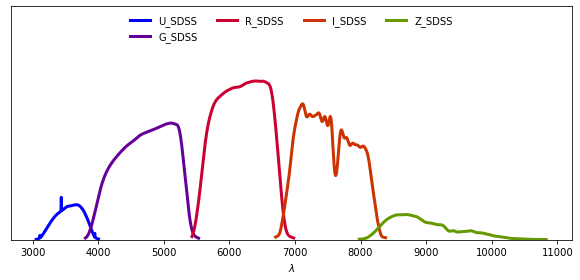

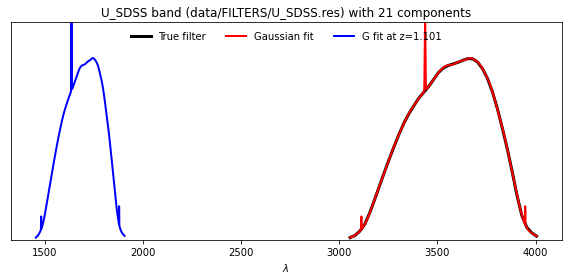

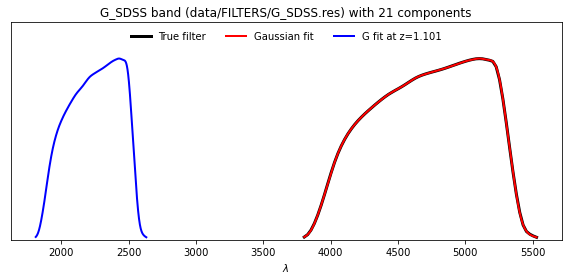

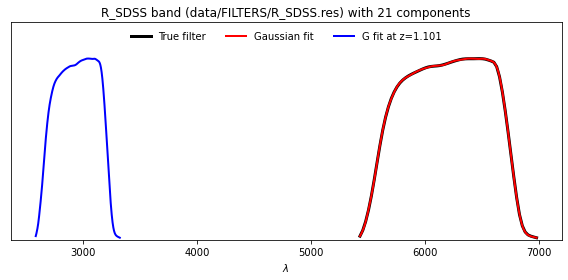

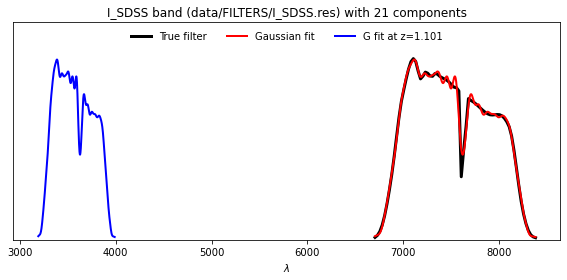

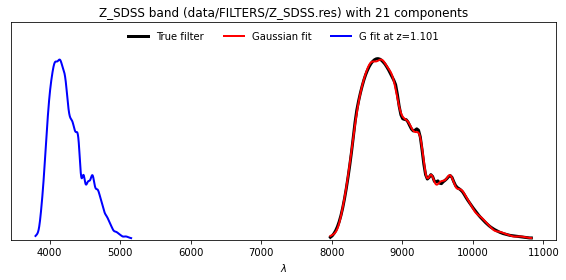

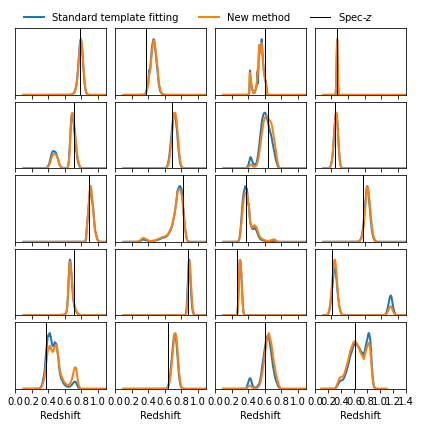

In [19]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(7, 6), sharex=True, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw, label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label=r'Spec-$z$')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 1.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


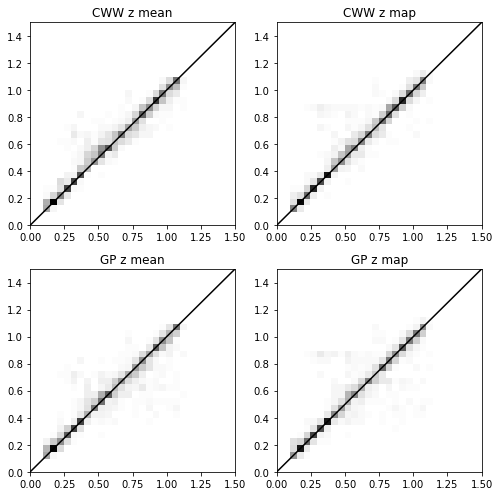

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
zmax = 1.5
rr = [[0, zmax], [0, zmax]]
nbins = 30
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
fig.tight_layout()

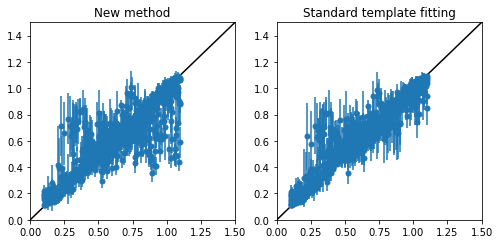

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[0].set_title('New method')
axs[1].set_title('Standard template fitting')

fig.tight_layout()

Text(0.5, 1.0, 'New method')

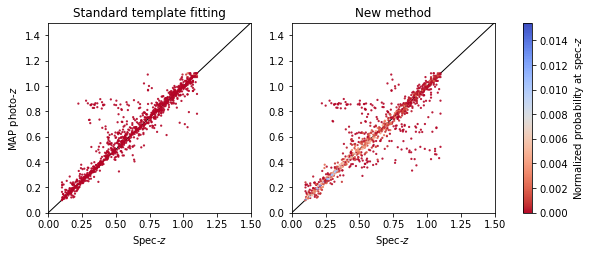

In [22]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.